In [1]:
#with diffusion
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.models import Model
from keras.layers import (
    Input,
    Activation,
    Conv3D,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
    concatenate,
    ReLU, Dropout,BatchNormalization
)

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.compat.v1.logging import INFO, set_verbosity

set_verbosity(INFO)

import tensorflow.python.keras.backend as K
K.set_image_data_format("channels_first")

In [2]:
def create_convolution_block(input_layer, n_filters, batch_normalization=False, kernel=(3, 3, 3), activation=None, padding='same', strides=(1, 1, 1), instance_normalization=False):

    layer = Conv3D(n_filters, kernel, padding=padding, strides=strides)(input_layer)
    act_layer=Activation('relu')(layer)
    bn_layer=BatchNormalization()(act_layer)
#     dr_layer=Dropout(0.4)(bn_layer)
    # if activation is None:
    #     return Activation('relu')(layer)
    # else:
    #     return activation()(layer)
    return bn_layer

# Defining upconvolution
def get_up_convolution(n_filters, pool_size, kernel_size=(3, 3, 3), strides=(1, 1, 1), deconvolution=False):
    if deconvolution:
        return Conv3DTranspose(filters=n_filters, kernel_size=kernel_size, padding='same',strides=strides)
    else:
        return UpSampling3D(size=pool_size)

# Defining the 3D unet model
def unet_model_3d(loss_function, input_shape=(32, 64, 64, 3), pool_size=(2, 2, 2), n_labels=3, initial_learning_rate=0.0001, deconvolution=False, depth=10, n_base_filters=32,
                  include_label_wise_dice_coefficients=False, metrics=[], batch_normalization=False, activation_name="sigmoid"):
  
    inputs = Input(input_shape)
    current_layer = inputs
    levels = list()

    # add levels with max pooling
    for layer_depth in range(depth):
        
        ##############################################
        n_filters=n_base_filters * (2 ** layer_depth)
        if n_filters>256:
            n_filters=256
        ##############################################
        layer1 = create_convolution_block(input_layer=current_layer, n_filters=n_filters, batch_normalization=batch_normalization)
        layer2 = create_convolution_block(input_layer=layer1, n_filters=n_filters * 2, batch_normalization=batch_normalization)
        if layer_depth < depth - 1 and layer_depth%2==0:
                                       ################
            current_layer = MaxPooling3D(pool_size=pool_size)(layer2)
            levels.append([layer1, layer2, current_layer])
        elif layer_depth < depth - 1 and layer_depth%2!=0:
                                         ################
            current_layer = MaxPooling3D(pool_size=(1,1,1),padding="same")(layer2)
                                        ##################################
            levels.append([layer1, layer2, current_layer])
        else:
            print("1*1",layer2.shape)
            current_layer = layer2
            print(current_layer.shape)
            levels.append([layer1, layer2])
    
    for layer_depth in range(depth - 2, -1, -1):
        
        if layer_depth%2==0:
           ################
            up_convolution = get_up_convolution(pool_size=pool_size, deconvolution=deconvolution, n_filters=current_layer.shape[1])(current_layer)
        elif layer_depth%2!=0:
            #################
            up_convolution = create_convolution_block(n_filters=levels[layer_depth][1].shape[4], input_layer=concat, batch_normalization=batch_normalization)
                             ########################
        concat = concatenate([up_convolution, levels[layer_depth][1]], axis=4)
        current_layer = create_convolution_block(n_filters=levels[layer_depth][1].shape[4], input_layer=concat, batch_normalization=batch_normalization)
        #current_layer=Dropout(0.5)(current_layer)
        current_layer = create_convolution_block(n_filters=levels[layer_depth][1].shape[4], input_layer=current_layer, batch_normalization=batch_normalization)
        #current_layer=Dropout(0.5)(current_layer)

    final_convolution = Conv3D(n_labels, (1, 1, 1))(current_layer)
    act = Activation(activation_name)(final_convolution)
    act=Dropout(0.5)(act)
    model = Model(inputs=inputs, outputs=act)

    if not isinstance(metrics, list):
        metrics = [metrics]

    model.compile(optimizer=Adam(lr=initial_learning_rate), loss=loss_function,
                  metrics=metrics)
    return model

# ins=(32, 64, 64,3)
# #model=unet_3d_model(ins,lfunc=dice_coefficient_loss,metrics=[dice_coefficient])
# model=unet_model_3d(dice_coefficient_loss,metrics=[dice_coefficient])
# model.summary()

In [3]:
# Loss Function and coefficients to be used during training:
def dice_coefficient(y_true, y_pred):
    smoothing_factor = 1
    flat_y_true = K.flatten(y_true)
    flat_y_pred = K.flatten(y_pred)
    return (2. * K.sum(flat_y_true * flat_y_pred) + smoothing_factor) / (K.sum(flat_y_true) + K.sum(flat_y_pred) + smoothing_factor)

def dice_coefficient_loss(y_true, y_pred):
    return 1 - dice_coefficient(y_true, y_pred)

In [4]:

ins=(32, 64, 64,3)
#model=unet_3d_model(ins,lfunc=dice_coefficient_loss,metrics=[dice_coefficient])
model=unet_model_3d(dice_coefficient_loss,metrics=[dice_coefficient])
model.summary()

1*1 (None, 1, 2, 2, 512)
(None, 1, 2, 2, 512)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d (Conv3D)                (None, 32, 64, 64,   2624        ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 activation (Activation)        (None, 32, 64, 64,   0           ['conv3d[0][0]']                 
                                32)             

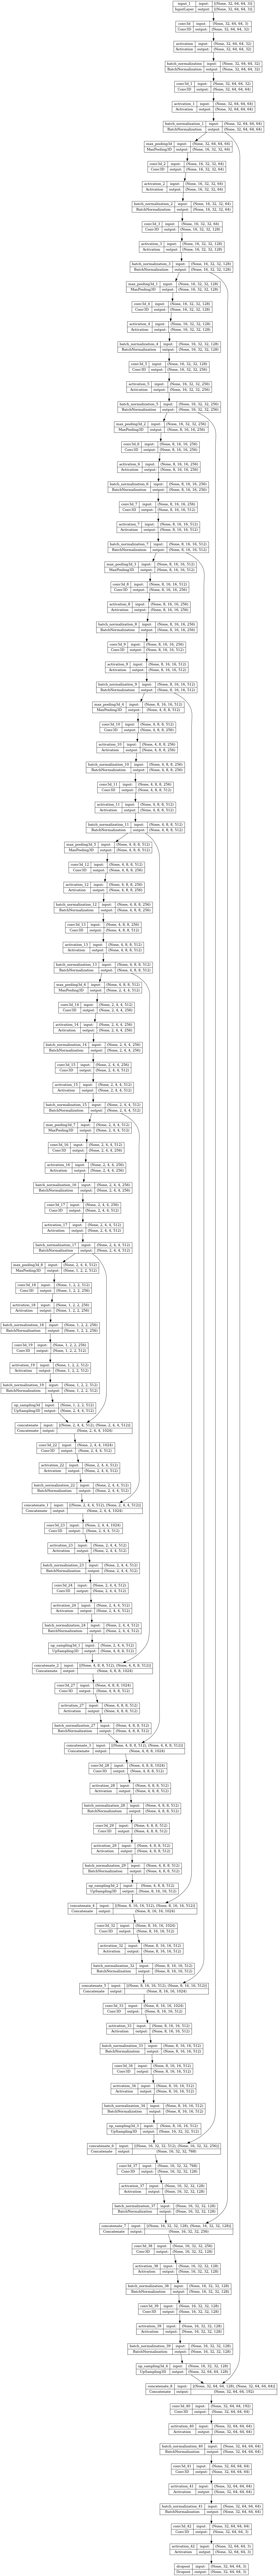

In [5]:
from keras.utils import plot_model
plot_model(model, to_file='mlp-mnist.png', show_shapes=True)

In [6]:
!pip install patchify

In [7]:
import numpy as np
import os
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [8]:
HOME_DIR = "../input/pddca-dataset/pddca/"
DATA_DIR = HOME_DIR

def load_case(imgfile, labelfile):
    # load the image and label file, get the image content and return a numpy array for each
    image = np.array(np.load(imgfile))
    label = np.array(np.load(labelfile))
    
    return image, label

In [9]:
img=[]
msk=[]
for dir in os.listdir(DATA_DIR):
    imfile=DATA_DIR+str(dir)+"/img_crp_v2.npy"
    lbfile=DATA_DIR+str(dir)+"/structures/mask.npy"
    if(os.path.isfile(lbfile)):
        im,ms=load_case(imfile,lbfile)
        img.append(im)
        msk.append(ms)

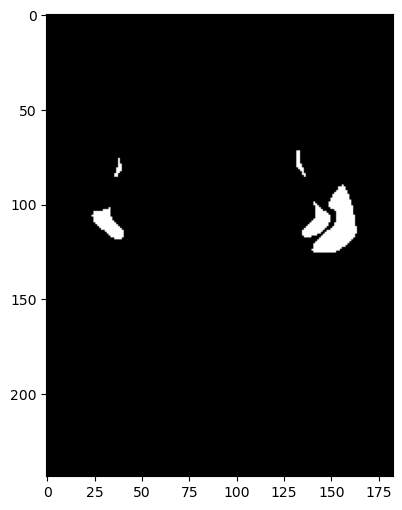

In [10]:
plt.figure(figsize=(14,6))
im1=msk[0]
plt.imshow(im1[36,:,:],cmap='gray')

In [11]:
from skimage.transform import resize
ns=(64,64,64,3)

from patchify import patchify
import tensorflow as tf


img_patches = patchify(img[0], (32, 64, 64), step=64)
mask_patches  = patchify(msk[0], (32, 64, 64), step=64)
input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))

train_img = np.stack((input_img,)*3, axis=-1)
train_mask = np.stack((input_mask,)*3, axis=-1)
# train_mask = to_categorical(input_mask, num_classes=3)

#train_img=np.expand_dims(train_img,axis=4)
#train_mask = np.expand_dims(input_mask, axis=4)


train_img=tf.cast(train_img, tf.float32)
train_mask=tf.cast(train_mask, tf.float32)
# print(train_img.shape)

# ins=(train_img.shape[0],64,64,64,3)
# mns=(train_mask.shape[0],64,64,64,3)
# train_img=resize(train_img,ins, mode='reflect', anti_aliasing=True)
# train_mask=resize(train_mask,mns, mode='reflect', anti_aliasing=True)

#print(train_img.shape)


img_patches1 = patchify(img[1], (32, 64, 64), step=64)
mask_patches1  = patchify(msk[1], (32, 64, 64), step=64)
input_img1 = np.reshape(img_patches1, (-1, img_patches1.shape[3], img_patches1.shape[4], img_patches1.shape[5]))
input_mask1 = np.reshape(mask_patches1, (-1, mask_patches1.shape[3], mask_patches1.shape[4], mask_patches1.shape[5]))

train_img1 = np.stack((input_img1,)*3, axis=-1)
train_mask1 = np.stack((input_mask1,)*3, axis=-1)
#train_mask1 = to_categorical(input_mask1, num_classes=3)
#train_img=np.expand_dims(train_img,axis=4)
#train_mask = np.expand_dims(input_mask, axis=4)

train_img1=tf.cast(train_img1, tf.float32)
train_mask1=tf.cast(train_mask1, tf.float32)
#tf.cast(train_mask_cat1, tf.float32)

# train_img1=resize(train_img1,ns, mode='reflect', anti_aliasing=True)
# train_mask1=resize(train_mask1,ns, mode='reflect', anti_aliasing=True)
# ins1=(train_img1.shape[0],64,64,64,3)
# mns1=(train_mask1.shape[0],64,64,64,3)
# train_img1=resize(train_img1,ins, mode='reflect', anti_aliasing=True)
# train_mask1=resize(train_mask1,mns, mode='reflect', anti_aliasing=True)

tri=np.concatenate((train_img,train_img1),axis=0)
trm=np.concatenate((train_mask,train_mask1),axis=0)
print(tri.shape)
print(trm.shape)

(15, 32, 64, 64, 3)
(15, 32, 64, 64, 3)


In [12]:
for i in range(2,len(img)):
    img_patches = patchify(img[i], (32, 64, 64), step=64)
    mask_patches  = patchify(msk[i], (32, 64, 64), step=64)
    input_img = np.reshape(img_patches, (-1, img_patches.shape[3], img_patches.shape[4], img_patches.shape[5]))
    input_mask = np.reshape(mask_patches, (-1, mask_patches.shape[3], mask_patches.shape[4], mask_patches.shape[5]))
    
    train_img = np.stack((input_img,)*3, axis=-1)
    train_mask = np.stack((input_mask,)*3, axis=-1)
      #train_mask = to_categorical(input_mask, num_classes=3)
      #train_img=np.expand_dims(train_img,axis=4)
      #train_mask = np.expand_dims(input_mask, axis=4)



      #train_mask_cat = to_categorical(input_mask, num_classes=3)
    train_img=tf.cast(train_img, tf.float32)
    train_mask=tf.cast(train_mask, tf.float32)
    
    
#     ins=(train_img.shape[0],64,64,64,3)
#     mns=(train_mask.shape[0],64,64,64,3)
#     train_img=resize(train_img,ins, mode='reflect', anti_aliasing=True)
#     train_mask=resize(train_mask,mns, mode='reflect', anti_aliasing=True)
    
#     train_img=resize(train_img,ns, mode='reflect', anti_aliasing=True)
#     train_mask=resize(train_mask,ns, mode='reflect', anti_aliasing=True)

    
    tri=np.concatenate((tri,train_img),axis=0)
    trm=np.concatenate((trm,train_mask),axis=0)


print(tri.shape)
print(trm.shape)

(346, 32, 64, 64, 3)
(346, 32, 64, 64, 3)


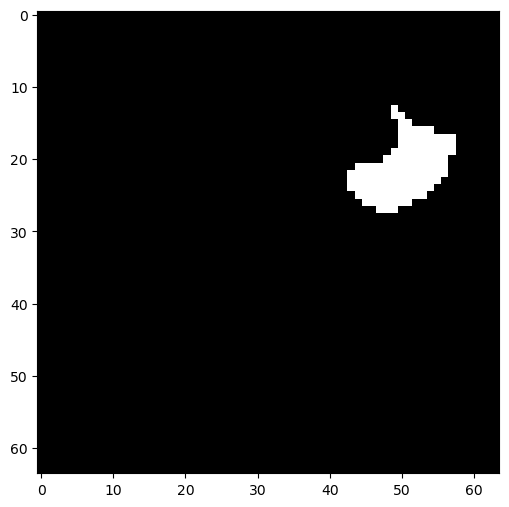

In [13]:
plt.figure(figsize=(14,6))
im1=trm[36]
plt.imshow(im1[26,:,:])

In [14]:
from sklearn.model_selection import train_test_split
#X_tr, X_val, y_tr, y_val = train_test_split(tri, trm, test_size = 0.10,random_state=42)
X_train, X_test, y_train, y_test = train_test_split(tri, trm, test_size = 0.1, random_state=9)

In [15]:
# history = model.fit(X_train,y_train,epochs=100,batch_size=16,validation_split=0.1)
model=unet_model_3d(dice_coefficient_loss,initial_learning_rate=0.0005, metrics=[dice_coefficient])
bs=24
for i in range(0,len(y_train),bs):
    X_batch=X_train[i:i+bs]
    y_batch=y_train[i:i+bs]
    history=model.fit(X_batch,y_batch,epochs=100,batch_size=8,validation_split=0.1)#,callbacks=EarlyStopping(monitor='val_loss',patience=3,mode='min')

1*1 (None, 1, 2, 2, 512)
(None, 1, 2, 2, 512)
Epoch 1/100
3/3 [==============================] - 93s 15s/step - loss: 0.8741 - dice_coefficient: 0.1330 - val_loss: 0.9986 - val_dice_coefficient: 0.0014
Epoch 2/100
3/3 [==============================] - 11s 4s/step - loss: 0.8300 - dice_coefficient: 0.1743 - val_loss: 0.9989 - val_dice_coefficient: 0.0011
Epoch 3/100
3/3 [==============================] - 12s 4s/step - loss: 0.8078 - dice_coefficient: 0.1994 - val_loss: 0.9981 - val_dice_coefficient: 0.0019
Epoch 4/100
3/3 [==============================] - 12s 4s/step - loss: 0.8043 - dice_coefficient: 0.1989 - val_loss: 0.9986 - val_dice_coefficient: 0.0014
Epoch 5/100
3/3 [==============================] - 12s 4s/step - loss: 0.7889 - dice_coefficient: 0.2000 - val_loss: 0.9989 - val_dice_coefficient: 0.0011
Epoch 6/100
3/3 [==============================] - 11s 4s/step - loss: 0.7875 - dice_coefficient: 0.2135 - val_loss: 0.9989 - val_dice_coefficient: 0.0011
Epoch 7/100
3/3 [======

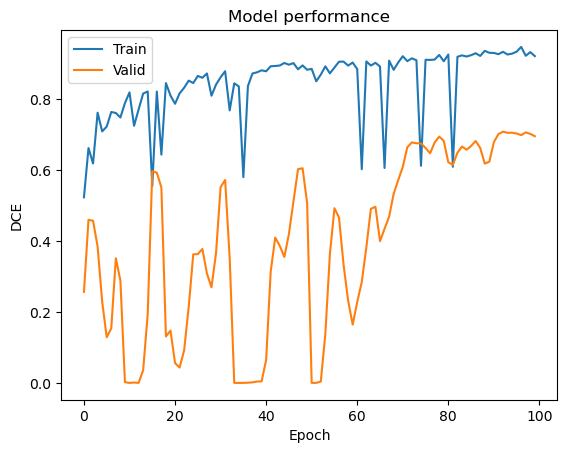

In [16]:
plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.title('Model performance')
plt.ylabel('DCE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()

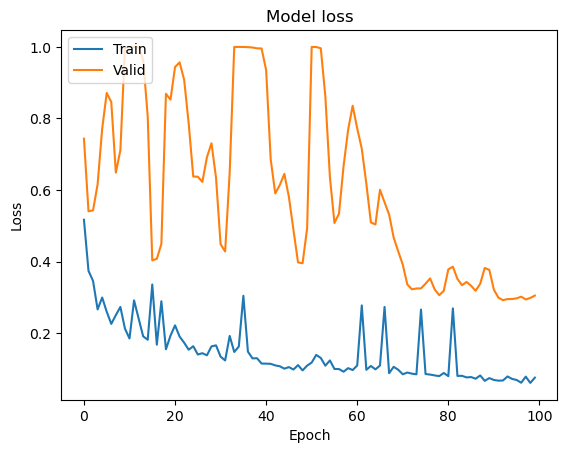

In [17]:
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch') 
plt.legend(['Train', 'Valid'], loc='upper left') 
plt.show()

In [18]:
pred=model.predict(X_test)
print(pred.shape)

2/2 [==============================] - 30s 27ms/step
(35, 32, 64, 64, 3)


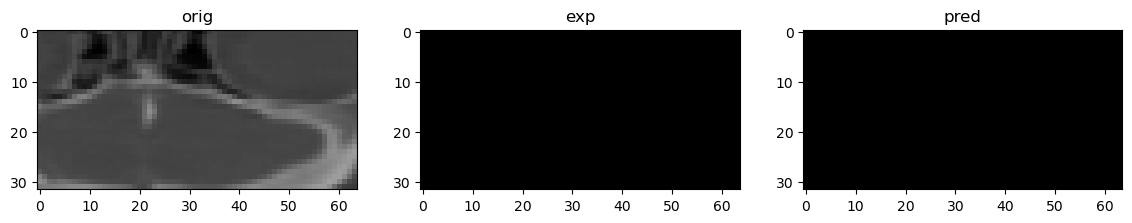

In [19]:
plt.figure(figsize=(14,6))

plt.subplot(131)
plt.title('orig')
plt.imshow(X_test[2][:,50,:],cmap='gray')


plt.subplot(132)
plt.title('exp')
plt.imshow(y_test[2][:,50,:],cmap='gray')

plt.subplot(133)
plt.title('pred')
plt.imshow(pred[2][:,50,:],cmap='gray')

In [20]:
res=model.evaluate(X_test,y_test,batch_size=8)
res

5/5 [==============================] - 5s 1s/step - loss: 0.3453 - dice_coefficient: 0.6738


[0.3452896177768707, 0.6738253831863403]

In [21]:
model.save('/kaggle/working/unet_model_20_04.h5')